In [24]:
import numpy as np
import random as rd
import scipy as sc
import math

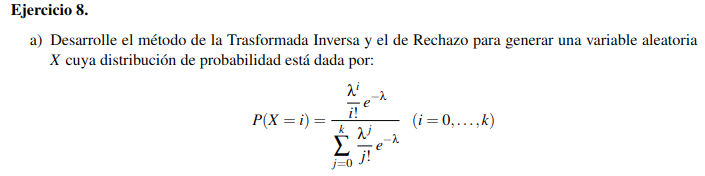
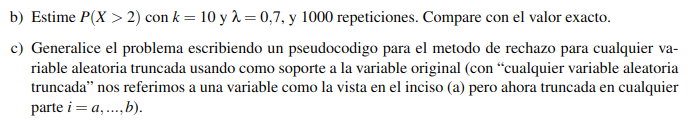

In [27]:
def sumatoria(k, lamda):
    suma = 0
    for i in range(k+1):
        suma += (lamda**i / math.factorial(i)) * np.exp(-lamda)
    return suma

def prob_x(k, lamda, i): # esto calcula P(X=i)
    suma = sumatoria(k, lamda)
    poisson = (lamda**i / math.factorial(i)) * np.exp(-lamda)
    return poisson / suma

def x_transformada_inversa(k, lamda):
    u = rd.random()
    F = prob_x(k, lamda, 0)
    i = 0
    while u >= F:
        i += 1
        F += prob_x(k, lamda, i)
    return i


0.9863047314016171


Para poder hacer el metodo de Rechazo, primero debemos saber que la variable soporte sera una Variable poisson con el mismo parametro lamda. Y tenemos que definir el c tal que

$$ 
\frac{P(X = i)}{P(Y = i)} \leq c \\ 
\text{Vemos que} \quad P(X = i) = \frac{P(Y = i)}{\sum_{j=0}^{k} \frac{\lambda^j}{j!} e^{-\lambda}} \\
\text{Entonces} \quad \frac{P(X = i)}{P(Y = i)} = \frac{1}{S} = c \\
$$
Entonces en el algoritmo de Rechazo generaremos un valor y de la variable Y (Distribuye Poisson) al valor aleatorio generado lo vamos a comparar con $$ \quad \frac{P(X = y)}{c P(Y = y)} $$
Donde si $y \gt k$ entocnes $P(X = y) = 0$ y siempre rechazamos. Y si $y \leq k$ entonces tendremos que 
$$
\frac{P(X = y)}{c P(Y = y)} = \frac{ \frac{P(Y = y)}{S} }{\frac{1}{S} P(Y = y)} = 1
$$
Es decir que si el valor generado por la variable Poisson Y esta entre 0 y k entonces aceptamos el valor generado. Y si es mayor a k entonces rechazamos.


In [18]:
def x_aceptacion_rechazo(k,lamda):
    while True:
        y = sc.stats.poisson.rvs(lamda)
        if 0 <= y <= k:
            return y

In [41]:
# Ahora calculo la prob de X > 2 de manera exacta
# P(X > 2) = 1 - P(X <= 2) = 1 - (P(X=0) + P(X=1) + P(X=2))
def prob_x_mayor_a_2(k, lamda):
    suma = 0
    for i in range(3):
        suma += prob_x(k, lamda, i)
    return 1 - suma

# ahora calculo usando transformada inversa
def prob_x_mayor_a_2_transformada_inversa(k, lamda, nsims):
    contador = 0
    for i in range(nsims):
        if x_transformada_inversa(k, lamda) > 2:
            contador += 1
    return contador / nsims

# ahora calculo usando aceptacion rechazo
def prob_x_mayor_a_2_aceptacion_rechazo(k, lamda, nsims):
    contador = 0
    for i in range(nsims):
        if x_aceptacion_rechazo(k, lamda) > 2:
            contador += 1
    return contador / nsims

def prob_x_mayor_a_2_aceptacion_rechazo_bis(k, lamda, nsims):
    contador = 0
    for i in range(nsims):
        if x_aceptacion_rechazo(k, lamda) <= 2:
            contador += 1
    return 1- (contador / nsims)

In [56]:
k = 10
lamda = 0.7
nsims = 10000
print(f"Estimacion con metodo t_i:{prob_x_mayor_a_2_transformada_inversa(k, lamda, nsims)}")

print(f"Estimacion con metodo a_r:{prob_x_mayor_a_2_aceptacion_rechazo(k, lamda, nsims)}")

print (f"Estimacion con metodo a_r bis:{prob_x_mayor_a_2_aceptacion_rechazo_bis(k, lamda, nsims)}")

print(f"Valor exacto: {prob_x_mayor_a_2(k, lamda)}")

Estimacion con metodo t_i:0.0374
Estimacion con metodo a_r:0.0347
Estimacion con metodo a_r bis:0.035499999999999976
Valor exacto: 0.03414158387347266


Ahora para poder generalizar el metodo del rechazo para Truncar cualquier variable (en este caso seria para Poisson) en un intervalo [a,b] tenemos que hacer lo siguiente:

In [57]:
def poisson_truncada(a, b, lamda):
    # genero una poisson con lambda con cualquier metodo
    # Transformada inversa, aceptacion rechazo, etc
    y = sc.stats.poisson.rvs(lamda)
    while not a <= y <= b:
        y = sc.stats.poisson.rvs(lamda)
    return y

In [70]:
# ejemplo, veamos cuantos valores da entre 3 y 7 con lamda 0,7
a = 3
b = 7
lamda = 0.7
nsims = 1000
simulacion = np.array([poisson_truncada(a, b, lamda) for i in range(nsims)])
print(np.unique(simulacion, return_counts=True))

(array([3, 4, 5, 6]), array([841, 142,  14,   3]))
